## Tic-Tac-Toe Agent
In this notebook, you will learn to build an RL agent (using Q-learning) that learns to play Numerical Tic-Tac-Toe with odd numbers. The environment is playing randomly with the agent, i.e. its strategy is to put an even number randomly in an empty cell. The following is the layout of the notebook:

        - Defining epsilon-greedy strategy
        - Tracking state-action pairs for convergence
        - Define hyperparameters for the Q-learning algorithm
        - Generating episode and applying Q-update equation
        - Checking convergence in Q-values

#### Importing libraries
Write the code to import Tic-Tac-Toe class from the environment file

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.insert(0,"/content/drive/MyDrive/Colab Notebooks/RL/Tic Tac Toe")
import TCGame_Env

In [3]:
# import your class from environment file
from TCGame_Env import TicTacToe 
import collections
import numpy as np
import random
import pickle
path = '/content/drive/MyDrive/Colab Notebooks/RL/Tic Tac Toe/'
import time
from matplotlib import pyplot as plt

env = TicTacToe()

In [4]:
# Function to convert state array into a string to store it as keys in the dictionary
# states in Q-dictionary will be of form: x-4-5-3-8-x-x-x-x
#   x | 4 | 5
#   ----------
#   3 | 8 | x
#   ----------
#   x | x | x

def Q_state(state):
    return ('-'.join(str(e) for e in state)).replace('nan','x')

In [5]:
# Defining a function which will return valid (all possible actions) actions corresponding to a state
# Important to avoid errors during deployment.

def valid_actions(state):

    valid_Actions = []
    
    valid_Actions = [i for i in env.action_space(state)[0]]
    return valid_Actions

In [6]:
# Defining a function which will add new Q-values to the Q-dictionary. 
def add_to_dict(state):
    state1 = Q_state(state)
    
    valid_act = valid_actions(state)
    if state1 not in Q_dict.keys():
        for action in valid_act:
            Q_dict[state1][action]=0

#### Epsilon-greedy strategy - Write your code here

(you can build your epsilon-decay function similar to the one given at the end of the notebook)

In [7]:
# Defining epsilon-greedy policy. You can choose any function epsilon-decay strategy

def epsilon_greedy(state, time):
    epsilon = min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*time)
    z = np.random.random()
        
    if z > epsilon:
        state1 = Q_state(state)
        action = max(Q_dict[state1],key=Q_dict[state1].get)   #Exploitation: this gets the action corresponding to max q-value of current state
        esp_phase = 'Exploitation'
    else:
        possible_actions = [act for act in env.action_space(state)[0]]        
        action = possible_actions[np.random.choice(range(len(possible_actions)))]    #Exploration: randomly choosing and action
        esp_phase = 'Exploration'
        #print("From Epsilon_greedy func:",action)
    return action, esp_phase

#### Tracking the state-action pairs for checking convergence - write your code here

In [8]:
# Initialise Q_dictionary as 'Q_dict' and States_tracked as 'States_track' (for convergence)
Q_dict = collections.defaultdict(dict)
States_track = collections.defaultdict(dict)

In [9]:
# Initialise states to be tracked
sample_q_values  = [('1-2-x-x-x-x-x-x-x',(6,5)),('x-x-3-4-x-x-x-x-x',(1,9)),('x-x-x-x-5-6-x-x-x',(7,3)),('x-x-x-x-x-x-x-x-x',(8,1)),
                    ('x-x-x-x-x-x-7-8-x',(9,7)),('1-2-3-4-x-x-x-x-x',(5,5))]    #select some 4 Q-values
def initialise_tracking_states():
        
    for q_values in sample_q_values:
        state  = q_values[0]
        action = q_values[1]
        States_track[state][action] = []  

In [10]:
#Defining a function to save the Q-dictionary as a pickle file

def save_obj(obj, name ):
    with open(path + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

In [11]:
def save_tracking_states():
    for state in States_track.keys():
        for action in States_track[state].keys():
            if state in Q_dict and action in Q_dict[state]:
                States_track[state][action].append(Q_dict[state][action])

In [12]:
initialise_tracking_states()

#### Define hyperparameters  ---write your code here

In [13]:
#Defining parameters for the experiment

EPISODES = 1500000
LR    = 0.03               # learning rate
GAMMA = 0.99                # discount factor

max_epsilon = 1.0
min_epsilon = 0.01
decay_rate  = 0.00001     # epsilon decay rate
threshold   = 10000         # no of episodes after which states_tracked wwill be saved
policy_threshold = 20000    # no of episodes after which Q dictionary/table will be saved
print_theshold   = 50000    # no of episodes after which print Win, loss and Tie count for this many episodes

### Q-update loop ---write your code here

- Steps followed for every Episodes:
1. Initialize states with 'nan' at the state of the Episode
2. Start the loop till no Terminal state
    - Calcuate Epsilon Greedy action 
    - Get the next State, reward and terminal state using env.step function
    - Calculate Win, Loss or Tie score based on rewards if it's terminal state
    - Calculate Q-value for current state 
    - Track the 4 states and save them at every threshold value
    - Save Q_dict at every policy threshold value
    - Printing elapse time, Win, Loss and Tie Count for every 10k episodes 
    - Reset Win, Loss and Tie count
    
3. Save final States_tracked and Q_dict after all the episodes

## Analysis/Conclusion

- Executed training for 1.5 Mn episodes
- Till ~50K episodes, model was doing Exploration and after that it has started Exploitation 
- After 1.25 Mn episodes, model has converged
- Model's winning ratio is ~91% of the games against Env having Random step strategy. 

Below is the outcome of last 50K games.
##### Win: 45503  Loss: 1245  Tie: 3252  Win % 91.01

In [14]:
start_time = time.time()

##To keep track of how many games are won/lost by Agent after every few episodes
agent_win =0
agent_loss = 0
tie = 0
exploration  =0
exploitation =0 

for episode in range(EPISODES):

    ##### Start writing your code from the next line
    env = TicTacToe() # creating an instance of the environment
    curr_state = env.state    
    #print("initial_state:",curr_state)
    
    add_to_dict(curr_state)  # adding the current state to dictionary
    done = False  
    
    while done != True:  
        curr_state_temp = Q_state(curr_state)
           
        curr_action,esp_phase = epsilon_greedy(curr_state, episode)  # applying epislon method
        if esp_phase=='Exploitation':
            exploitation +=1
        else:
            exploration +=1            
               
        next_state, reward, done = env.step(curr_state, curr_action) # Get Next State , Rewards and check if Game is over or can continue
       
        add_to_dict(next_state)
        next_state_temp = Q_state(next_state)
        
        ## Checking if it's win, loss or tie for agent and couting the same
        if done==True:
            if reward == 10:
                agent_win+=1
            elif reward == -10:
                agent_loss+=1
            else:
                tie +=1
        
        # Calculate Q-value for current state 
        if done != True:
            max_next = max(Q_dict[next_state_temp],key=Q_dict[next_state_temp].get)  
                        
            #this gets the action corresponding to max q-value of next state
            Q_dict[curr_state_temp][curr_action] += LR * ((reward + (GAMMA*(Q_dict[next_state_temp][max_next]))) - Q_dict[curr_state_temp][curr_action]) 
        else:
            Q_dict[curr_state_temp][curr_action] += LR * ((reward - Q_dict[curr_state_temp][curr_action]))

        # navigating to next state
        curr_state = next_state  #state(t) became state(t-1)
        
    #states tracking   
    if ((episode+1)%threshold)==0:
        save_tracking_states()
        save_obj(States_track,'States_tracking')

    if ((episode+1)% policy_threshold) == 0:  #At every policy threshold, the Q-dict will be saved
        save_obj(Q_dict,'Policy_Q_dict')  
        
    ## Print How many episodes are completed with Elapsed time, Win, Loss and Tie Ratio and Exploration/Exploitation phase (based on max count)    
    if ((episode+1)%print_theshold == 0):
        if exploitation > exploration:
            esp_phase='Exploitation'
        else:
            esp_phase='Exploration'
            
        print("Episodes completed: ",(episode+1)," Time (min): ",round((time.time()-start_time)/60,3)," Epsilon Phase:",esp_phase," Win:",agent_win," Loss:",agent_loss,
              " Tie:",tie," Win %",round(agent_win/(agent_win+agent_loss+tie)*100,2))
        agent_win   =0
        agent_loss  =0
        tie         =0
        exploitation=0
        exploration =0
    
    
elapsed_time = round((time.time() - start_time)/60,3)
print("Total Time (min):" ,elapsed_time)

save_obj(States_track,'States_tracked')   
save_obj(Q_dict,'Policy')

Episodes completed:  50000  Time (min):  0.838  Epsilon Phase: Exploration  Win: 12643  Loss: 14335  Tie: 23022  Win % 25.29
Episodes completed:  100000  Time (min):  1.587  Epsilon Phase: Exploitation  Win: 13298  Loss: 13760  Tie: 22942  Win % 26.6
Episodes completed:  150000  Time (min):  2.284  Epsilon Phase: Exploitation  Win: 13632  Loss: 13632  Tie: 22736  Win % 27.26
Episodes completed:  200000  Time (min):  2.989  Epsilon Phase: Exploitation  Win: 14551  Loss: 13149  Tie: 22300  Win % 29.1
Episodes completed:  250000  Time (min):  3.65  Epsilon Phase: Exploitation  Win: 15375  Loss: 12820  Tie: 21805  Win % 30.75
Episodes completed:  300000  Time (min):  4.349  Epsilon Phase: Exploitation  Win: 16080  Loss: 12297  Tie: 21623  Win % 32.16
Episodes completed:  350000  Time (min):  5.01  Epsilon Phase: Exploitation  Win: 16747  Loss: 12180  Tie: 21073  Win % 33.49
Episodes completed:  400000  Time (min):  5.817  Epsilon Phase: Exploitation  Win: 18779  Loss: 11297  Tie: 19924  Wi

#### Check the Q-dictionary

In [15]:
len(Q_dict)

808162

In [16]:
# try checking for one of the states - that which action your agent thinks is the best  -----This will not be evaluated
sorted(Q_dict['1-2-x-x-x-x-x-x-x'].items(), key=lambda kv: kv[1], reverse=True)[:10]

[((5, 7), -0.26257587310507174),
 ((5, 9), -0.26257587310507174),
 ((6, 3), -0.26257587310507174),
 ((6, 5), -0.26257587310507174),
 ((6, 7), -0.26257587310507174),
 ((7, 3), -0.26257587310507174),
 ((7, 7), -0.26257587310507174),
 ((7, 9), -0.26257587310507174),
 ((8, 3), -0.26257587310507174),
 ((8, 5), -0.26257587310507174)]

#### Check the states tracked for Q-values convergence
(non-evaluative)

In [17]:
# Write the code for plotting the graphs for state-action pairs tracked
#States_track

<function matplotlib.pyplot.show>

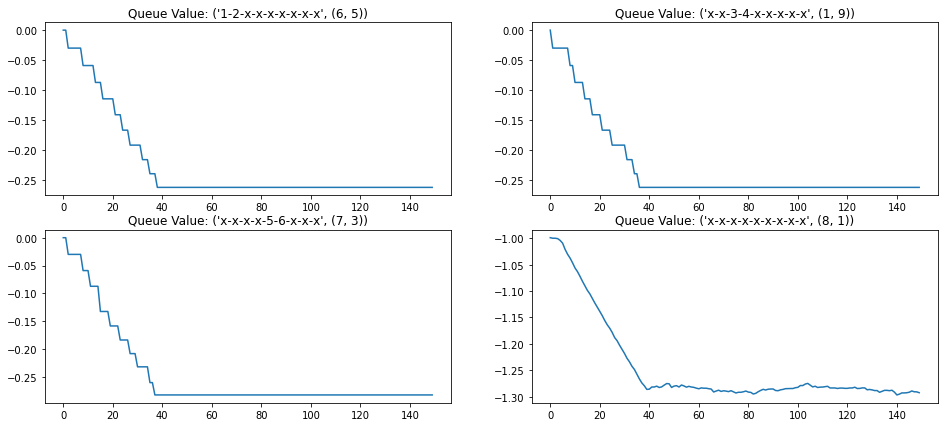

In [18]:
plt.figure(0, figsize=(16,7))

x_axis = np.asarray(range(0, len(States_track[sample_q_values[0][0]][sample_q_values[0][1]])))
#x_axis = np.asarray(range(0,EPISODES//threshold))
plt.subplot(221)
plt.plot(x_axis,np.asarray(States_track[sample_q_values[0][0]][sample_q_values[0][1]]))
plt.title("Queue Value: "+str(sample_q_values[0]))
plt.show

x_axis = np.asarray(range(0, len(States_track[sample_q_values[1][0]][sample_q_values[1][1]])))
plt.subplot(222)
plt.plot(x_axis,np.asarray(States_track[sample_q_values[1][0]][sample_q_values[1][1]]))
plt.title("Queue Value: "+str(sample_q_values[1]))
plt.show

x_axis = np.asarray(range(0, len(States_track[sample_q_values[2][0]][sample_q_values[2][1]])))
plt.subplot(223)
plt.plot(x_axis,np.asarray(States_track[sample_q_values[2][0]][sample_q_values[2][1]]))
plt.title("Queue Value: "+str(sample_q_values[2]))
plt.show

x_axis = np.asarray(range(0, len(States_track[sample_q_values[3][0]][sample_q_values[3][1]])))
plt.subplot(224)
plt.plot(x_axis,np.asarray(States_track[sample_q_values[3][0]][sample_q_values[3][1]]))
plt.title("Queue Value: "+str(sample_q_values[3]))
plt.show

### Epsilon - decay check

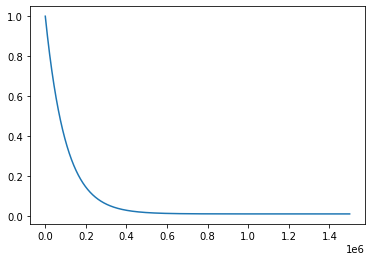

In [19]:
time = np.arange(0,EPISODES)
epsilon = []
for i in range(0,EPISODES):
    epsilon.append(min_epsilon + (max_epsilon - min_epsilon) * np.exp(-decay_rate*i))
    
plt.plot(time, epsilon)
plt.show()

In [21]:
with open('/content/drive/MyDrive/Colab Notebooks/RL/Tic Tac Toe/States_tracked.pkl', 'rb') as handle:
  States_track = pickle.load(handle)